In [15]:
#Extracts the contents of a zip file containing the dataset to a specified directory
import zipfile
import os
import shutil
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model


zip_path = '/content/num+plate.zip'
extract_to = 'dataset'


os.makedirs(extract_to, exist_ok=True)


with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Extracted {zip_path} to {extract_to}/")


Extracted /content/num+plate.zip to dataset/


In [16]:
#Creates a directory for augmented data and sets up an image data generator
aug = "aug_data"
os.makedirs(aug, exist_ok=True)

datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [18]:
# performs data augmentation by resizing images, applying random transformations like rotation, zoom, and flips,
num_plate_folder = os.path.join(extract_to, "num plate")

for class_folder in os.listdir(num_plate_folder):
    class_path = os.path.join(num_plate_folder, class_folder)
    aug_class_path = os.path.join(aug, class_folder)
    os.makedirs(aug_class_path, exist_ok=True)

    if os.path.isdir(class_path):
        images = os.listdir(class_path)


        for img_name in images:
            try:
                shutil.copy(os.path.join(class_path, img_name), os.path.join(aug_class_path, img_name))
            except:
                continue


        aug_count = 0
        img_cycle = iter(images)

        while aug_count < 1000:
            try:
                img_name = next(img_cycle)
            except StopIteration:
                img_cycle = iter(images)
                img_name = next(img_cycle)

            try:
                img_path = os.path.join(class_path, img_name)
                img = Image.open(img_path).convert("RGB").resize((256, 256))
                img_array = np.expand_dims(np.array(img), 0)
                aug_iter = datagen.flow(img_array, batch_size=1)
                aug_img = next(aug_iter)[0].astype(np.uint8)
                aug_pil = Image.fromarray(aug_img)
                aug_pil.save(os.path.join(aug_class_path, f"{img_name.split('.')[0]}_extra{aug_count}.jpg"))
                aug_count += 1
            except:
                continue

In [19]:
#splits the augmented image data into training and testing sets, creating directories for each class and copying the corresponding images into the respective train and test directories.
train_dir = "processed/train"
test_dir = "processed/test"
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

for class_folder in os.listdir(aug):
    class_path = os.path.join(aug, class_folder)

    if os.path.isdir(class_path):
        images = os.listdir(class_path)
        if len(images) == 0:
            print(f"No images found for class {class_folder}.")
            continue

        train_imgs, test_imgs = train_test_split(images, test_size=0.05, random_state=42)

        os.makedirs(os.path.join(train_dir, class_folder), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_folder), exist_ok=True)

        for img in train_imgs:
            shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, class_folder, img))
        for img in test_imgs:
            shutil.copy(os.path.join(class_path, img), os.path.join(test_dir, class_folder, img))


In [20]:
#defines a function to preprocess images by converting them to grayscale, resizing them to 128x128 pixels,
def preprocess_and_save(input_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    for class_folder in os.listdir(input_dir):
        class_path = os.path.join(input_dir, class_folder)
        save_path = os.path.join(output_dir, class_folder)
        os.makedirs(save_path, exist_ok=True)
        for img_file in os.listdir(class_path):
            try:
                img = Image.open(os.path.join(class_path, img_file)).convert("L")
                img = img.resize((128, 128))
                img.save(os.path.join(save_path, img_file))
            except:
                pass

preprocess_and_save(train_dir, "final/train")
preprocess_and_save(test_dir, "final/test")


if not os.listdir(train_dir):
    print("train_dir is empty")
else:
    sample_class = os.listdir(train_dir)[0]
    sample_img_name = os.listdir(os.path.join(train_dir, sample_class))[0]

    original_img = Image.open(os.path.join(train_dir, sample_class, sample_img_name))
    processed_img = Image.open(os.path.join("final/train", sample_class, sample_img_name))

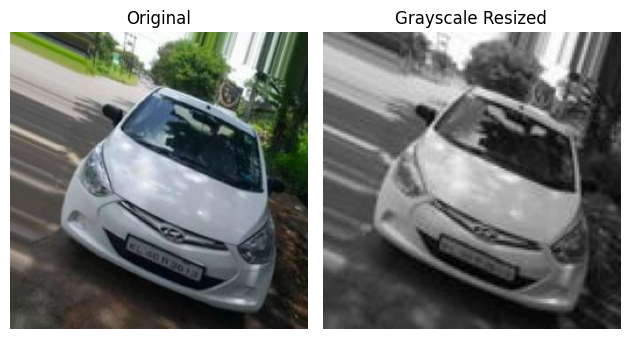

In [21]:
sample_class = os.listdir(train_dir)[0]
sample_img_name = os.listdir(os.path.join(train_dir, sample_class))[0]

original_img = Image.open(os.path.join(train_dir, sample_class, sample_img_name))
processed_img = Image.open(os.path.join("final/train", sample_class, sample_img_name))

plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(original_img)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Grayscale Resized")
plt.imshow(processed_img, cmap='gray')
plt.axis("off")

plt.tight_layout()
plt.show()


In [22]:
train_path = 'final/train'
test_path = 'final/test'


In [23]:
final_path = "final"

for split in ["train", "test"]:
    split_path = os.path.join(final_path, split)
    total = 0
    print(f"\nIn '{split}' folder:")
    for class_folder in os.listdir(split_path):
        class_path = os.path.join(split_path, class_folder)
        if os.path.isdir(class_path):
            count = len(os.listdir(class_path))
            total += count
            print(f"  {class_folder}: {count} images")
    print(f"Total images in '{split}': {total}")



In 'train' folder:
  KL: 969 images
  DL: 992 images
  GJ: 980 images
  WB: 978 images
  CG: 976 images
  LA: 953 images
  OD: 974 images
  KA: 975 images
  HR: 974 images
  AS: 975 images
  UP: 975 images
  BR: 971 images
  ML: 992 images
  HP: 974 images
  AP: 992 images
  TR: 962 images
  PY: 970 images
  RJ: 960 images
  NL: 961 images
  AN: 960 images
  TN: 962 images
  JK: 982 images
  PB: 980 images
  MZ: 953 images
  DN: 961 images
  UK: 962 images
  TS: 971 images
  CH: 962 images
  JH: 972 images
  AR: 963 images
  SK: 969 images
  MP: 963 images
  MH: 975 images
  MN: 959 images
  GA: 969 images
Total images in 'train': 33966

In 'test' folder:
  KL: 57 images
  DL: 58 images
  GJ: 59 images
  WB: 59 images
  CG: 57 images
  LA: 57 images
  OD: 57 images
  KA: 57 images
  HR: 57 images
  AS: 58 images
  UP: 58 images
  BR: 57 images
  ML: 58 images
  HP: 57 images
  AP: 57 images
  TR: 57 images
  PY: 56 images
  RJ: 57 images
  NL: 56 images
  AN: 57 images
  TN: 57 images

In [24]:
img_size = (128, 128)
batch_size = 35

In [25]:
#normalize pixel values. It then loads the images , resizing them, converting them to grayscale
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_path,
    target_size=img_size,
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical'
)

test_data = test_datagen.flow_from_directory(
    test_path,
    target_size=img_size,
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical'
)

num_classes = len(train_data.class_indices)

Found 33966 images belonging to 35 classes.
Found 2003 images belonging to 35 classes.


In [26]:
model = Sequential([  # Initializing a sequential model
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),  # 32 filters and 3x3 kernels, activation is relu
    MaxPooling2D((2, 2)),  # reducing spatial dimension, while saving the imp info

    Conv2D(64, (3, 3), activation='relu'),  # Second convolutional layer with 64 filters and 3x3 kernel
    MaxPooling2D((2, 2)), # reducing spatial dimension, while saving the imp info

    Conv2D(128, (3, 3), activation='relu'),  # Third convolutional layer with 128 filters and 3x3 kernel
    MaxPooling2D((2, 2)),  # reducing spatial dimension, while saving the imp info

    Flatten(),  # 2D to 1D
    Dense(128, activation='relu'),  #defines 128 neurons receiving input from the flattened vector while each has its own set of weights
    Dropout(0.5),  # it randomly sets 50% of the input to zero to prevent overfitting
    Dense(num_classes, activation='softmax')  # multi-class classification
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint("best_model.h5", monitor='val_accuracy', save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(
    train_data,
    epochs=24,
    validation_data=test_data,
    callbacks=[checkpoint, early_stop]
)

model.load_weights("best_model.h5")
loss, accuracy = model.evaluate(test_data)
print(f"\nTest Accuracy: {accuracy * 100:.2f}%")

model.save("final_model.h5")


Epoch 1/24
969/971 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.0909 - loss: 3.3745

971/971 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.0910 - loss: 3.3739 - val_accuracy: 0.3235 - val_loss: 2.5358
Epoch 2/24
971/971 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2808 - loss: 2.5865

971/971 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - accuracy: 0.2808 - loss: 2.5864 - val_accuracy: 0.5527 - val_loss: 1.7785
Epoch 3/24
971/971 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4229 - loss: 1.9905

971/971 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - accuracy: 0.4230 - loss: 1.9904 - val_accuracy: 0.6480 - val_loss: 1.3415
Epoch 4/24
968/971 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5306 - loss: 1.5652

971/971 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - accuracy: 0.5306 - loss: 1.5652 - val_accuracy: 0.7179 - val_loss: 1.0455
Epoch 5/24
971/971 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5996 - loss: 1.3100

971/971 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - accuracy: 0.5996 - loss: 1.3100 - val_accuracy: 0.7713 - val_loss: 0.8550
Epoch 6/24
970/971 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6508 - loss: 1.1248

971/971 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.6508 - loss: 1.1248 - val_accuracy: 0.7903 - val_loss: 0.7657
Epoch 7/24
970/971 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6867 - loss: 0.9844

971/971 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.6867 - loss: 0.9844 - val_accuracy: 0.8123 - val_loss: 0.6578
Epoch 8/24
969/971 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7250 - loss: 0.8687

971/971 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - accuracy: 0.7250 - loss: 0.8688 - val_accuracy: 0.8243 - val_loss: 0.6182
Epoch 9/24
968/971 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7481 - loss: 0.7896

971/971 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.7481 - loss: 0.7896 - val_accuracy: 0.8492 - val_loss: 0.5317
Epoch 10/24
971/971 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.7693 - loss: 0.7053 - val_accuracy: 0.8487 - val_loss: 0.5205
Epoch 11/24
970/971 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7839 - loss: 0.6681

971/971 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.7839 - loss: 0.6681 - val_accuracy: 0.8552 - val_loss: 0.4993
Epoch 12/24
971/971 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7990 - loss: 0.6152

971/971 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - accuracy: 0.7990 - loss: 0.6152 - val_accuracy: 0.8627 - val_loss: 0.4847
Epoch 13/24
971/971 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - accuracy: 0.8148 - loss: 0.5665 - val_accuracy: 0.8552 - val_loss: 0.5143
Epoch 14/24
971/971 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8199 - loss: 0.5452

971/971 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.8199 - loss: 0.5452 - val_accuracy: 0.8647 - val_loss: 0.4769
Epoch 15/24
970/971 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8349 - loss: 0.5025

971/971 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.8349 - loss: 0.5026 - val_accuracy: 0.8677 - val_loss: 0.4879
Epoch 16/24
970/971 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8331 - loss: 0.4992

971/971 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.8331 - loss: 0.4992 - val_accuracy: 0.8702 - val_loss: 0.4617
Epoch 17/24
971/971 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8481 - loss: 0.4581

971/971 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - accuracy: 0.8481 - loss: 0.4581 - val_accuracy: 0.8712 - val_loss: 0.4636
Epoch 18/24
971/971 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8537 - loss: 0.4418

971/971 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.8537 - loss: 0.4419 - val_accuracy: 0.8797 - val_loss: 0.4286
Epoch 19/24
971/971 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8600 - loss: 0.4300

971/971 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.8600 - loss: 0.4300 - val_accuracy: 0.8817 - val_loss: 0.4210
Epoch 20/24
971/971 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8658 - loss: 0.4057

971/971 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - accuracy: 0.8658 - loss: 0.4057 - val_accuracy: 0.8892 - val_loss: 0.4221
Epoch 21/24
969/971 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8757 - loss: 0.3718

971/971 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.8757 - loss: 0.3718 - val_accuracy: 0.8927 - val_loss: 0.4108
Epoch 22/24
971/971 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - accuracy: 0.8750 - loss: 0.3692 - val_accuracy: 0.8872 - val_loss: 0.4277
Epoch 23/24
971/971 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - accuracy: 0.8787 - loss: 0.3641 - val_accuracy: 0.8917 - val_loss: 0.4171
Epoch 24/24
971/971 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - accuracy: 0.8918 - loss: 0.3378 - val_accuracy: 0.8902 - val_loss: 0.4151
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8887 - loss: 0.4228



Test Accuracy: 89.27%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


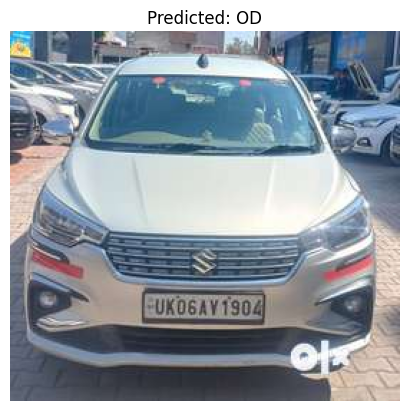

Predicted class: OD


In [29]:
model = load_model("final_model.h5")

def preprocess_image(img_path):
    img = Image.open(img_path).convert("L")
    img = img.resize((128, 128))
    img_array = np.array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    img_array = np.expand_dims(img_array, axis=-1)
    return img_array


img_path = '/content/image.jpeg'
img = preprocess_image(img_path)

prediction = model.predict(img)

predicted_class_index = np.argmax(prediction, axis=1)
class_labels = list(train_data.class_indices.keys())
predicted_class = class_labels[predicted_class_index[0]]


img_show = Image.open(img_path)
plt.imshow(img_show)
plt.title(f"Predicted: {predicted_class}")
plt.axis('off')
plt.show()

print(f"Predicted class: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


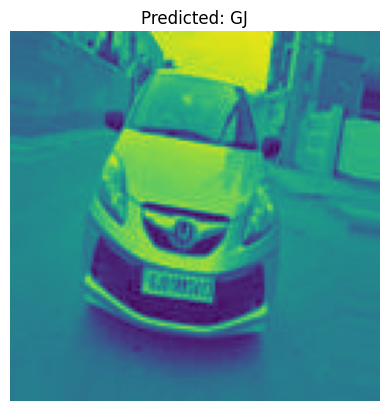

Predicted class: GJ


In [30]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from PIL import Image


model = load_model("final_model.h5")


def preprocess_image(img_path):
    img = Image.open(img_path).convert("L")
    img = img.resize((128, 128))
    img_array = np.array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    img_array = np.expand_dims(img_array, axis=-1)
    return img_array


img_path = '/content/shuffle_14_aug66.jpg'


img = preprocess_image(img_path)

prediction = model.predict(img)


predicted_class_index = np.argmax(prediction, axis=1)
class_labels = list(train_data.class_indices.keys())
predicted_class = class_labels[predicted_class_index[0]]


img_show = Image.open(img_path)
plt.imshow(img_show)
plt.title(f"Predicted: {predicted_class}")
plt.axis('off')
plt.show()

print(f"Predicted class: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


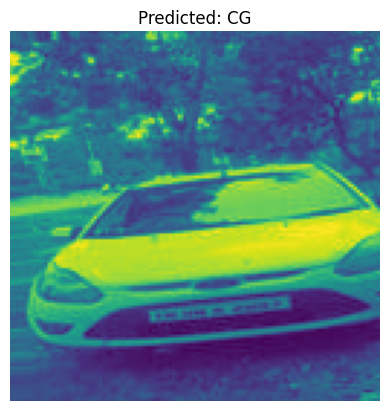

Predicted class: CG


In [31]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from PIL import Image


model = load_model("final_model.h5")


def preprocess_image(img_path):
    img = Image.open(img_path).convert("L")
    img = img.resize((128, 128))
    img_array = np.array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    img_array = np.expand_dims(img_array, axis=-1)
    return img_array


img_path = '/content/final/test/CG/shuffle_10_extra57.jpg'


img = preprocess_image(img_path)

prediction = model.predict(img)


predicted_class_index = np.argmax(prediction, axis=1)
class_labels = list(train_data.class_indices.keys())
predicted_class = class_labels[predicted_class_index[0]]


img_show = Image.open(img_path)
plt.imshow(img_show)
plt.title(f"Predicted: {predicted_class}")
plt.axis('off')
plt.show()

print(f"Predicted class: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


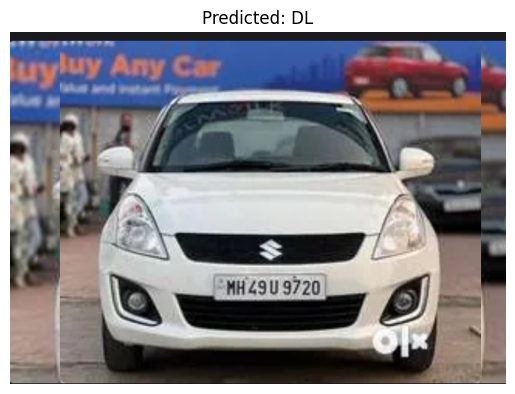

Predicted class: DL


In [32]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from PIL import Image


model = load_model("final_model.h5")


def preprocess_image(img_path):
    img = Image.open(img_path).convert("L")
    img = img.resize((128, 128))
    img_array = np.array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    img_array = np.expand_dims(img_array, axis=-1)
    return img_array


img_path = '/content/ii2.jpg'


img = preprocess_image(img_path)

prediction = model.predict(img)


predicted_class_index = np.argmax(prediction, axis=1)
class_labels = list(train_data.class_indices.keys())
predicted_class = class_labels[predicted_class_index[0]]


img_show = Image.open(img_path)
plt.imshow(img_show)
plt.title(f"Predicted: {predicted_class}")
plt.axis('off')
plt.show()

print(f"Predicted class: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


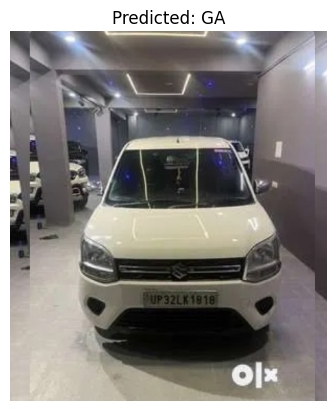

Predicted class: GA


In [33]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from PIL import Image


model = load_model("final_model.h5")


def preprocess_image(img_path):
    img = Image.open(img_path).convert("L")
    img = img.resize((128, 128))
    img_array = np.array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    img_array = np.expand_dims(img_array, axis=-1)
    return img_array


img_path = '/content/ii3.jpg'


img = preprocess_image(img_path)

prediction = model.predict(img)


predicted_class_index = np.argmax(prediction, axis=1)
class_labels = list(train_data.class_indices.keys())
predicted_class = class_labels[predicted_class_index[0]]


img_show = Image.open(img_path)
plt.imshow(img_show)
plt.title(f"Predicted: {predicted_class}")
plt.axis('off')
plt.show()

print(f"Predicted class: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


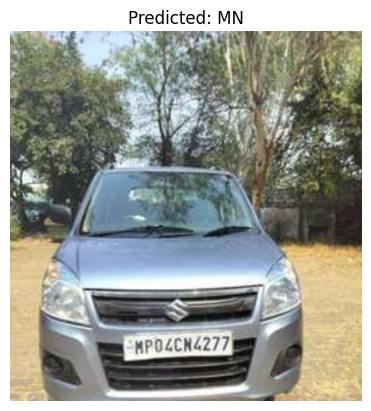

Predicted class: MN


In [34]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from PIL import Image


model = load_model("final_model.h5")


def preprocess_image(img_path):
    img = Image.open(img_path).convert("L")
    img = img.resize((128, 128))
    img_array = np.array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    img_array = np.expand_dims(img_array, axis=-1)
    return img_array


img_path = '/content/ii4.jpg'


img = preprocess_image(img_path)

prediction = model.predict(img)


predicted_class_index = np.argmax(prediction, axis=1)
class_labels = list(train_data.class_indices.keys())
predicted_class = class_labels[predicted_class_index[0]]


img_show = Image.open(img_path)
plt.imshow(img_show)
plt.title(f"Predicted: {predicted_class}")
plt.axis('off')
plt.show()

print(f"Predicted class: {predicted_class}")
